In [1]:
from typing import List, Dict, Any

import pandas as pd
import torch
from torch import nn
from gbnet.xgbmodule import XGBModule
from gbnet.lgbmodule import LGBModule

import xgboost as xgb



class HazardIntegrator(nn.Module):
    def __init__(self, covariate_cols: List[str] = [], params={}, min_hess=0):
        """
        Parameters
        ----------
        covariate_cols
            Columns to feed into the model. "time" is always included.
        """
        super().__init__()
        self.params = params.copy()
        self.min_hess = min_hess
        self.covariate_cols = covariate_cols
        self.gb_module = None

    def forward(self, df: pd.DataFrame) -> Dict[str, Any]:
        # TODO - freeze the training set after it gets read once
        # to avoid significant overhead in generating it for each
        # round of training
        if {"unit_id", "time"} - set(df.columns):
            raise ValueError("DataFrame must contain 'unit_id' and 'time'.")

        # 1. Sort (unit_id, time) – stable so original relative order inside ties is kept
        df_sorted = df.sort_values(["unit_id", "time"], kind="mergesort").reset_index()
        orig_idx = torch.as_tensor(df_sorted.pop("index").values, dtype=torch.long)
        interleave_amts = torch.tensor(
            df_sorted.groupby('unit_id').size().values,
            dtype=torch.int64
        )

        # 2. Build tensors -------------------------------------------------
        unit_codes, uniques = pd.factorize(df_sorted["unit_id"])
        unit_ids = torch.as_tensor(unit_codes, dtype=torch.long)
        times = torch.as_tensor(df_sorted["time"].values, dtype=torch.float32)

        # Select covariate columns
        covar_cols = ['time'] + self.covariate_cols
        X = df_sorted[covar_cols].values

        if self.gb_module is None:
            self.gb_module = XGBModule(X.shape[0], len(covar_cols), 1, params=self.params, min_hess=self.min_hess)
        
        # 3. Model inference ----------------------------------------------
        log_hazard = self.gb_module(xgb.DMatrix(df_sorted[covar_cols], enable_categorical=True)).flatten()  # [N]
        hazard = torch.exp(log_hazard)            # λ(t)

        # 4. Trapezoidal slice per row ------------------------------------
        dt = torch.diff(times, prepend=times.new_zeros(1))
        same_unit = torch.diff(unit_ids, prepend=unit_ids.new_tensor([-1])).eq(0)
        dt = dt * same_unit.float()

        trapz_slice = 0.5 * (hazard + torch.roll(hazard, 1)) * dt
        trapz_slice[~same_unit] = 0.0

        unit_Lambda = torch.zeros(
            [df['unit_id'].drop_duplicates().shape[0]]
        ).scatter_reduce(0, unit_ids, trapz_slice, reduce='sum')

        # this mask can be frozen (ie not regenerated each training round)
        mask = torch.cat((
            unit_ids[1:] != unit_ids[:-1],        
            torch.tensor([True], device=unit_ids.device)
        ))
        last_hazard = hazard[mask]

        unsort = torch.argsort(orig_idx)
        hazard_unsort = hazard[unsort]

        # Get entire Survival function NOT EFFICIENT; COMMENT OUT IF NOT NEEDED
        Lambda_global = torch.cumsum(trapz_slice, dim=0)              # still carries
        sub_Lambda = torch.roll(unit_Lambda, 1, 0)
        sub_Lambda[0] = 0
        sub_Lambda = torch.repeat_interleave(torch.cumsum(sub_Lambda, 0), interleave_amts)
        Lambda = Lambda_global - sub_Lambda
        
        # 6️⃣  Survival function S(t) = exp(‑Λ(t)) ──────────────────────────────
        survival = torch.exp(-Lambda)
        
        # 7️⃣  Expected value 𝔼[T] = ∫ S(t) dt  (discrete trapezoid) ───────────
        # NOTE THAT THIS WILL NOT INTEGRATE PAST THE LAST DATA POINT PER UNIT
        # SO THIS IS NOT REALLY A GOOD VERSION OF E[T]
        surv_slice = 0.5 * (survival + torch.roll(survival, 1)) * dt
        surv_slice[~same_unit] = 0.0                                  # don’t mix units
        
        unit_E = torch.zeros_like(unit_Lambda).scatter_reduce(
            0, unit_ids, surv_slice, reduce="sum"                     # ∑ S(t) Δt  per unit
        )
        
        # 8️⃣  Put everything back in original row order ───────────────────────
        survival_unsort = survival[unsort]
        
        return {
            "hazard":                hazard_unsort,
            "unit_last_hazard":      last_hazard,
            "unit_integrated_hazard":unit_Lambda,
            "survival":              survival_unsort,   # S(t) for every row (optional)
            "unit_expected_time":    unit_E,            # 𝔼[T]  per unit
        }

    def gb_step(self):
        self.gb_module.gb_step()


In [2]:
import pandas as pd
import numpy as np

def expand_overlapping_units_locf(
    df: pd.DataFrame,
    unit_col: str = "unit_id",
    time_col: str = "time",
    fill_value=np.nan,
):
    # Unique times observed anywhere in the data, sorted
    all_times = np.sort(df[time_col].unique())

    # Min & max time for each unit
    t_min = df.groupby(unit_col)[time_col].min()
    t_max = df.groupby(unit_col)[time_col].max()

    # Skeleton of unit–time combinations
    pieces = []
    for unit in t_min.index:
        mask = (all_times >= t_min[unit]) & (all_times <= t_max[unit])
        pieces.append(pd.DataFrame({unit_col: unit, time_col: all_times[mask]}))
    skeleton = pd.concat(pieces, ignore_index=True)

    # Merge and sort
    out = (
        skeleton
        .merge(df, on=[unit_col, time_col], how="left")
        .sort_values([unit_col, time_col], kind="mergesort")
        .reset_index(drop=True)
    )

    # Identify covariate columns (excluding unit and time)
    covariate_cols = [col for col in df.columns if col not in {unit_col, time_col}]

    # LOCF: forward fill per unit
    out[covariate_cols] = out.groupby(unit_col)[covariate_cols].ffill()

    # Optional: still fill any remaining NaNs (e.g., if a unit starts mid-way)
    out[covariate_cols] = out[covariate_cols].fillna(fill_value)

    return out



def to_integration_df(df):
    
    df['unit_id'] = range(len(df))
    unit_metadata = df[['unit_id', 'event']]
    return (
        pd.concat([
            df,
            pd.DataFrame([{'unit_id': i, 'time': 0} for i in range(df.shape[0])])
        ])[['unit_id', 'time']].merge(
            unit_metadata,
            on='unit_id', how='inner',
            validate='many_to_one'
        ).sort_values(['unit_id', 'time']).reset_index(drop=True),
        df
    )



In [3]:
from lifelines.datasets import load_dd

dd = load_dd()
edf, mdf = to_integration_df(dd.rename(columns={'observed': 'event', 'duration': 'time'}))
mdf = mdf.sort_values(['unit_id', 'time']).reset_index(drop=True).copy()

cat_cols = ['ctryname', 'cowcode2', 'politycode', 'un_region_name', 'un_continent_name', 'democracy', 'regime']
cnt_cols = ['start_year']

edf = edf.merge(mdf[
    ['unit_id'] + cat_cols + cnt_cols
], on='unit_id', how='left', validate='many_to_one')


exp_df = expand_overlapping_units_locf(edf)
exp_df = exp_df.sort_values(["unit_id", "time"], kind="mergesort").reset_index()

for c in cat_cols:
    exp_df[c] = exp_df[c].astype('category')

In [5]:
exp_df.head(10)

,index,unit_id,time,event,ctryname,cowcode2,politycode,un_region_name,un_continent_name,democracy,regime,start_year
0,0,0,0,1.0,Afghanistan,700.0,700.0,Southern Asia,Asia,Non-democracy,Monarchy,1946.0
1,1,0,1,1.0,Afghanistan,700.0,700.0,Southern Asia,Asia,Non-democracy,Monarchy,1946.0
2,2,0,2,1.0,Afghanistan,700.0,700.0,Southern Asia,Asia,Non-democracy,Monarchy,1946.0
3,3,0,3,1.0,Afghanistan,700.0,700.0,Southern Asia,Asia,Non-democracy,Monarchy,1946.0
4,4,0,4,1.0,Afghanistan,700.0,700.0,Southern Asia,Asia,Non-democracy,Monarchy,1946.0
5,5,0,5,1.0,Afghanistan,700.0,700.0,Southern Asia,Asia,Non-democracy,Monarchy,1946.0
6,6,0,6,1.0,Afghanistan,700.0,700.0,Southern Asia,Asia,Non-democracy,Monarchy,1946.0
7,7,0,7,1.0,Afghanistan,700.0,700.0,Southern Asia,Asia,Non-democracy,Monarchy,1946.0
8,8,1,0,1.0,Afghanistan,700.0,700.0,Southern Asia,Asia,Non-democracy,Civilian Dict,1953.0
9,9,1,1,1.0,Afghanistan,700.0,700.0,Southern Asia,Asia,Non-democracy,Civilian Dict,1953.0


In [11]:
integrator = HazardIntegrator(
    covariate_cols=cat_cols + cnt_cols,
    params={},
    # min_hess=min_hess
)

losses = []
for i in range(100):
    integrator.train()
    integrator.zero_grad()
    
    out = integrator(exp_df)
    
    # n log-lik loss
    loss = (
        out['unit_integrated_hazard'].sum() - (torch.log(out['unit_last_hazard']) * torch.Tensor(mdf['event'] == 1)).sum()
    ) / mdf.shape[0]
    loss.backward(create_graph=True)
    losses.append(loss.item())
    
    integrator.gb_step()

integrator.eval()

out = integrator(exp_df)

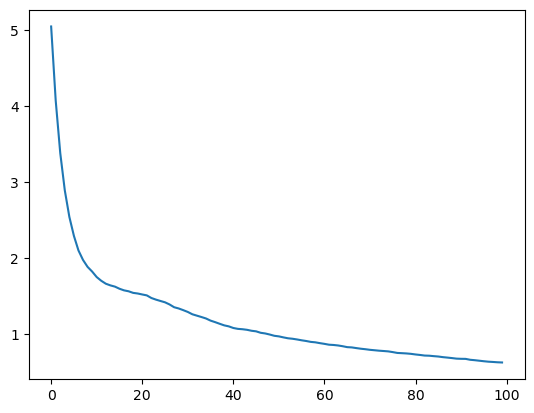

In [13]:
plt.plot(losses)

In [16]:
from lifelines.utils import concordance_index

# NOTE THAT UNIT_EXPECTED_TIME IS LIKELY WRONG HERE:
# Expected value 𝔼[T] = ∫ S(t) dt
# BUT THIS DATASET DOES NOT INTEGRATE PAST THE LAST DATA POINT PER UNIT
# SO THIS IS NOT REALLY A GOOD VERSION OF E[T]
concordance_index(mdf['time'], out['unit_expected_time'], mdf['event']==1)  

0.989589643157149